In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import os
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
import multiprocessing
from pickle import load
import sklearn
import sklearn.preprocessing 
from generate_data import export_virtual_data
from get_data_cal_ut import generate_data_calibration
from protomodels import mises, tresca

In [253]:
current_dir = "./"  # Assuming current directory
dir = "/"
if os.name == "nt":
    current_dir = ".\\"
    dir = "\\"

In [254]:
"---------------------------------------------------------------- PARAMETERS ---------------------------------------------------------------------------------------------"
material = "DP780"
gseed = 6
enu = 0.3
density = 7.85e-9
nb_virtual_pt = 20
degree = 4
weigth_exp = 0.9
protomodel = "mises"
law = "voce"


gen_v_data = False
gen_e_data = False
adapt = False
export_coeff_abq = True
export_coeff_user = True
plot = False
opti = True

In [255]:
"""----------------------------------------------------------------- GENERATING DATA ----------------------------------------------------------------------------------"""
thetas = ["00", "15", "30", "45", "60", "75", "90"]
materials = ["AA7020-T6", "DP600", "DP780"]
if gen_v_data :
    print("Virtual data generating")
    if protomodel == "mises":
        export_virtual_data(mises, protomodel, material, nb_virtual_pt)
    if protomodel == "tresca":
        export_virtual_data(tresca, protomodel, material, nb_virtual_pt)
    print("Generation ended")
if gen_e_data:
    generate_data_calibration(material, thetas)

In [256]:
""" ----------------------------------------------------------- READ DATA ----------------------------------------------------------------------------------------------"""
def readData(material, protomodel):
    """
        Input :
            - material : string
            - protomodel : string
    """
    filename_v = "data_virtual_" + material + "_" + protomodel + ".csv"
    filepath_v = current_dir + material + "_results" + dir + "DATA" + dir + filename_v

    df_v = pd.read_csv(filepath_v)

    filename_e = "data_cal_" + material + ".csv"
    filepath_e = current_dir + material + "_results" + dir + "DATA" + dir + filename_e

    df_e = pd.read_csv(filepath_e)

    sigma0 = df_e["YieldStress"].iloc[0]

    df_e["s11"] = df_e["YieldStress"] / sigma0 * (np.square(np.cos(df_e["LoadAngle"])) + df_e["q"] * np.square(np.sin(df_e["LoadAngle"])))
    df_e["s22"] = df_e["YieldStress"] / sigma0 * (np.square(np.sin(df_e["LoadAngle"])) + df_e["q"] * np.square(np.cos(df_e["LoadAngle"])))
    df_e["s33"] = df_e["YieldStress"] * 0
    df_e["s12"] = df_e["YieldStress"] / sigma0 * (1 - df_e["q"]) * np.sin(df_e["LoadAngle"]) * np.cos(df_e["LoadAngle"]) / sigma0
    df_e["s13"] = df_e["YieldStress"] * 0
    df_e["s23"] = df_e["YieldStress"] * 0
    df_e.loc[df_e["Rval"] == "*", "Rval"] = 10

    df = pd.concat([df_e, df_v])

    print(df.head())

    df["d11"] = (2/3) * df["s11"] - (1/3) * df["s22"] - (1/3) * df["s33"]
    df["d22"] = - (1/3) * df["s11"] + (2/3) * df["s22"] - (1/3) * df["s33"]

    return(df)

df = readData(material, protomodel)
nb_virtual_pt = len(df[df["Type"] == "v"])

data = df[["d11", "d22", "s12", "s13", "s23","LoadAngle", "Rval"]].values

     q  LoadAngle  YieldStress                Rval Type       s11       s22  \
0  0.0        0.0   473.122214  0.8220526766666666    e  1.000000  0.000000   
1  0.0       15.0   473.972404  0.8060485733333334    e  0.578163  0.423634   
2  0.0       30.0   483.296154          0.81121214    e  0.024305  0.997199   
3  0.0       45.0   484.596251  0.8559026033333333    e  0.282656  0.741596   
4  0.0       60.0   483.774351  0.9013175666666667    e  0.927513  0.095001   

   s33       s12  s13  s23  
0  0.0  0.000000  0.0  0.0  
1  0.0 -0.001046  0.0  0.0  
2  0.0 -0.000329  0.0  0.0  
3  0.0  0.000968  0.0  0.0  
4  0.0  0.000627  0.0  0.0  


In [257]:
"""------------------------ MODEL AND SCALER LOADING -------------------------------------------------"""
number = 1

def custom_activation(x):
    return 0.5 * (1 + tf.math.sign(x)) * (x + 1/100) +  0.5 * (1 - tf.math.sign(x)) * tf.math.exp(tf.math.minimum(0.0,x)) / 100

model = Sequential([])
model.add(Input(shape=(22,)))
model.add(Dense(200, activation=custom_activation, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-7.0, maxval=7.0, seed=gseed)))
model.add(Dense(200, activation=custom_activation))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

folderpath = f"{current_dir}convexity_domain{dir}NN{dir}"

filename_model = folderpath + f"model_{number}.keras"
filename_weights = folderpath + f"model_weights_{number}.weights.h5"
filename_scaler = folderpath + f"scaler_{number}.pkl"

X_scaler = load(open(filename_scaler, 'rb'))
model.load_weights(filename_weights)

mean = X_scaler.mean_
std = np.sqrt(X_scaler.var_)


#Small test
if degree==2:
    C = np.array([3, 3, 3, 3, 3, 3])
if degree==4:
    C = np.array([9, 18, 27, 18, 9, 18, 18, 18, 9, 18, 18, 18, 18, 9, 0, 0, 18, 18, 18, 18, 18, 9])

print(model.predict(X_scaler.transform(np.atleast_2d(C)))[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1.0


c:\Users\cnober\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [258]:
"""------------------------------------POLYN PARAMETERS---------------------------------------------------------"""

def get_param_polyN(degree):
    """
        Returns the parameters of polyN according to the degree
        Input :
            - degree : integer, degree of the polyN function
        Output :
            - nmon : integer, number of monomials im the polyN function of degree n
            - nmon_abq : integer, number of monomials of degree n in a homogeneous function of degree n
            - powers : ndarray of shape (nmon, 5), powers[i, j] is the power of the variable j in the monomial i
    """
    x0 = np.zeros((2,5))
    polyN = sklearn.preprocessing.PolynomialFeatures((degree, degree), include_bias=False)
    X = polyN.fit_transform(x0)
    powers = polyN.powers_
    nmon_abq = len(powers)

    selected_indices = []
    for i in range(nmon_abq):
        k,l,m,n,p = powers[i]
        if ((m==n) and (n==p)) or ((m%2==0) and (n%2==0) and (p%2==0)):
            selected_indices.append(i)

    powers = powers[selected_indices].T
    X = X[:,selected_indices]

    sorted_indices = np.lexsort((powers[1], powers[2], powers[3], powers[4]))
    powers = powers.T[sorted_indices]
    X = X[:,sorted_indices]

    ndata, nmon = X.shape

    return(powers, nmon, nmon_abq)

powers, nmon, nmon_abq = get_param_polyN(degree)

In [259]:
""" ---------------------------------------------------POLYN DEFINITION------------------------------------------------------------------------------"""
def dev(S):
    """
        Returns the deviatoric stress.
        Input :
            - S : ndarray of shape (n,6) or (6,), stress components in 3D
        Output :
            - D : ndarray of shape (n,6), deviatoric stress components in 3D
    
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = S.copy()
    trace_dev = S[:,0] + S[:,1] + S[:,2]
    D[:,0] = S[:,0] - (1/3) * trace_dev
    D[:,1] = S[:,1] - (1/3) * trace_dev
    D[:,2] = S[:,2] - (1/3) * trace_dev
    return(D)

def polyN(S, coeff):
    """
        Compute the polyN function.
        Input :
            - S : ndarray of shape (n,6) or (6,), stress components in 3D
            - coeff : ndarray of shape (nmon,), coefficients of the polyN function
        Output :
            - res : float, result of polyN
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]
    res = np.zeros(len(X))
    for i in range(nmon) :
        p = powers[i]
        res = res + coeff[i] * np.prod(X ** p, axis=1)
    return(res)

"""---------------------------------------------- GRADIENT AND HESSIAN OF POLYN DEFINITION -----------------------------------------------------------"""

#True we lose time here but ok

def jac_dev():
    """
        Returns the jacobian of the deviatoric operator
        Output :
            - jac : ndarray of shape (5,6)
    """
    jac = np.zeros((5, 6))
    jac[0] = np.array([2/3, -1/3, -1/3, 0, 0, 0])
    jac[1] = np.array([-1/3, 2/3, -1/3, 0, 0, 0])
    jac[2] = np.array([0, 0, 0, 1, 0, 0])
    jac[3] = np.array([0, 0, 0, 0, 1, 0])
    jac[4] = np.array([0, 0, 0, 0, 0, 1])
   
    return(jac)

def jac_polyN_param(coeff, powers):
    """
        Compute the different parameters and coefficients to compute the Jacobian of polyN
        Input :
            - coeff (float ndarray of shape (nmon)) : Coefficients of the polyN function
            ordered by power[1] asc, power[2] asc, power[3] asc, power[4] asc
            - powers (float ndarray of shape (nmon, 5)) : Powers for each monomial of the 
            PolyN function
        
        Output :
            - coeff_grad (float ndarray of shape (5, nmon)) : coeff_grad[i] contains the 
            coefficients of each monomial derived with respect to dev[i]
            - powers_grad (float ndarray of shape (5, nmon, 5)) : powers_grad[i,j] contains
            the monomial j derived with respect to dev[i]
    """

    coeff_grad = np.zeros((5, coeff.shape[0]))
    powers_grad = np.zeros((5, powers.shape[0], powers.shape[1]))
    for i in range(5):
        coeff_grad[i] = coeff * powers[:,i]
        subs = np.zeros(powers_grad[i].shape)
        subs[:,i] = -1
        powers_grad[i] = np.maximum(0,powers + subs)
    
    return(coeff_grad, powers_grad)

def grad_polyN(S, coeff_grad, powers_grad):
    """
        Input :
            - S : float ndarray of shape (n, 6) or (6,), stress components in 3d
            - coeff_grad : float ndarray of shape (5, nmon),coeff_grad[i] contains the 
            coefficients of each monomial derived with respect to dev[i]
            - powers_grad : float ndarray of shape (5, nmon, 5) : powers_grad[i][j] contains
            the monomial j derived with respect to i-th deviatoric component
        
        Output :
            - grad : ndarray of shape (n, 6), grad_polyN[i, j] = dpolyN/dsj of the i-th data
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]

    grad_polyN = np.zeros(6)
    grad_f = np.zeros((len(X),5))

    for i in range(5):
        for j in range(nmon):
            p = powers_grad[i][j]
            grad_f[:,i] = grad_f[:,i] + coeff_grad[i][j] * np.prod(X ** p, axis=1)
    
    jac_d = jac_dev()

    grad_polyN = np.dot(grad_f, jac_d)
    return(grad_polyN)

def hessian_polyN_param(coeff_grad, powers_grad):
    """
    Compute the different parameters and coefficients to compute the Hessian of polyN
        Input :
            - coeff_grad : float ndarray of shape (5, nmon), coeff_grad[i] contains the 
            coefficients of dpolyN/ddev[i]
            - powers_grad : float ndarray of shape (5, nmon, 5), powers_grad[i,j] contains
            the powers of dmon[j]/ddev[i]
        
        Output :
            - coeff_hessian : float ndarray of shape (5, 5, nmon)), coeff_hessian[i,j,k] contains
            the coefficients of d2mon[k]/ddev[j]ddev[i] 
            - powers_hessian : float ndarray of shape (5, 5, nmon, 5), powers_hessian[i,j,k]contains
            the powers of d2mon[k]/ddev[j]ddev[i] 

    """
    coeff_hessian = np.zeros((5, coeff_grad.shape[0], coeff_grad.shape[1]))
    powers_hessian = np.zeros((5, powers_grad.shape[0], powers_grad.shape[1], powers_grad.shape[2]))

    for i in range(5):
        for j in range(5):
            coeff_hessian[i][j] = coeff_grad[i] * powers_grad[i,:,j]
            subs = np.zeros(powers_hessian[i][j].shape)
            subs[:,j] = -1
            powers_hessian[i][j] = np.maximum(0,powers_grad[i] + subs)
    
    return(coeff_hessian, powers_hessian)

def hessian_polyN(S, coeff_hessian, powers_hessian):
    """
        Compute the hessian of polyN.
        Input :
            - S : float ndarray of shape (n, 6) or (6,), stress components in 3d
            - coeff_hessian : float ndarray of shape (5, 5, nmon)), coeff_hessian[i,j,k] contains
            the coefficients of d2mon[k]/ddev[j]ddev[i] 
            - powers_hessian : float ndarray of shape (5, 5, nmon, 5), powers_hessian[i,j,k]contains
            the powers of d2mon[k]/ddev[j]ddev[i] 
        Output :
            - hessian : float ndarray of shape (n, 6, 6), hessian[i,j,k] = dpolyN/ds[k]ds[j] of the ith data pt

    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]

    hessian_polyN = np.zeros((6,6))
    jac_grad_f = np.zeros((len(X), 5, 5))

    for i in range(5):
        for j in range(5):
            for k in range(nmon):
                p = powers_hessian[i][j][k]
                jac_grad_f[:,i,j] = jac_grad_f[:,i,j] + coeff_hessian[i][j][k] * np.prod(X ** p, axis=1)
    
    jac_d = jac_dev(S)
    hessian_polyN = np.transpose(np.dot(jac_d.T,np.dot(jac_grad_f[:], jac_d)), (1, 2, 0))
    return(hessian_polyN)

In [260]:
""" ---------------------------------------------PARAMETERS OPTIMIZATION-----------------------------------------------------------------------------"""

if degree==2:
    C = np.array([3, 3, 3, 3, 3, 3])
if degree==4:
    C = np.array([9, 18, 27, 18, 9, 18, 18, 18, 9, 18, 18, 18, 18, 9, 0, 0, 18, 18, 18, 18, 18, 9])

def optiCoeff_polyN(data, degree, weigth_exp):
    """
    
    """
    polyN = sklearn.preprocessing.PolynomialFeatures((degree, degree), include_bias=False)
    X = polyN.fit_transform(data[:, :5],)
    powers = polyN.powers_

    selected_indices = []
    for i in range(nmon_abq):
        k,l,m,n,p = powers[i]
        if ((m==n) and (n==p)) or ((m%2==0) and (n%2==0) and (p%2==0)):
            selected_indices.append(i)

    powers = powers[selected_indices].T
    X = X[:,selected_indices]

    sorted_indices = np.lexsort((powers[1], powers[2], powers[3], powers[4]))
    powers = powers.T[sorted_indices]
    X = X[:,sorted_indices]

    weigth = np.where(df["Type"] == "e", weigth_exp, 1-weigth_exp)
    ndata = X.shape[0]

    M = np.zeros((nmon, nmon))

    print(nmon)
    for i in range(ndata):
        Xi = np.expand_dims(X[i], axis=0)
        M = M + weigth[i] * np.dot(Xi.T, Xi)
    M = M / 2

    V = np.sum(np.expand_dims(weigth, axis=1) * X, axis = 0)

    D = np.sum(weigth, axis = 0)

    #We work with scaled data to optimize using neural network's gradient and loss' gradient in the same space of coefficients

    def J(a):
        return np.dot(np.dot(a, M), a) - np.dot(V, a) + D

    def Grad_J(a):
        return np.dot(grad_scaler, 2 * np.dot(M, a) - V)

    def J_norm(a_norm):
        a = np.array(X_scaler.inverse_transform(np.atleast_2d(a_norm)))[0]
        return np.dot(np.dot(a, M), a) - np.dot(V, a) + D
    
    grad_scaler = np.diag(1/std)

    def Grad_J_norm(a_norm):
        a = np.array(X_scaler.inverse_transform(np.atleast_2d(a_norm)))[0]
        return np.dot(grad_scaler, 2 * np.dot(M, a) - V)


    #Random starting point?
    a = np.zeros(len(powers))
    a[0] = 1

    print("Start optimizing")
    
    #Optimization on not scaled data
    opt = scipy.optimize.minimize(J, a, method='BFGS', jac=Grad_J)
    a_test = opt.x

    #Optimization on scaled data
    opt_norm = scipy.optimize.minimize(J_norm, a, method='BFGS', jac=Grad_J_norm)
    a = np.atleast_2d(opt_norm.x)

    J_val = J_norm(a)

    #print("Coefficients without scaling", a_test)
    #print("Coefficients with scaling in between", X_scaler.inverse_transform(a))

    #Estimation that a polyN function is convex when model(coeff) > 0.5 + tau
    tau = 0
    res = model.predict(a)[0,0] - 0.5 - tau


    if res < 0 :
        #Prediction without contraints not convex according to our criteria on tau

        M0 = X_scaler.transform(np.atleast_2d(C))
        lamb = 0.5 #scaling factor
        eps_sigma = 0.001
        eps_model = 0.0001
        itermax = 100
        i = 0
        use_tc = True #bool representing convexity of the current solution
        sigma = np.ones(nmon)

        while np.linalg.norm(sigma) > eps_sigma and (i < itermax) or (i == 1):

            if use_tc :
                #bisection method to find the point of the border
                #of the convexity domain between the current solution a
                #and M0 (Mises)
                S = M0
                E = a
                res = - 0.5 - tau
                j = 0

                while abs(res) > eps_model:
                    I = (S + E) / 2
                    res = model(I)[0,0] - 0.5 -  tau
                        
                    if res < 0 :
                        E = I
                    else :
                        S = I
                        
                    j = j + 1

                b = tf.constant(I, name = "b")

                with tf.GradientTape() as tape :
                        tape.watch(b)
                        output = model(b)

                grad_b = tape.gradient(output, b)
                n = grad_b / np.linalg.norm(grad_b)

            else :
                #a is predicted convex so basic gradient descent
                b = a
                n = np.zeros(22)
                
            grad_a = Grad_J_norm(a)
            sigma = - grad_a + (np.dot(grad_a, n[0])) * n
            a = b + lamb * sigma

            res = model(a)[0,0] - 0.5 - tau

            if res < 0 :
                #a not in the convexity domain
                use_tc = True
            else:
                #a in the convexity domain
                use_tc = False

            i = i + 1
    
    J_val_fin = J_norm(a)
    score = model.predict(a)[0,0]
    print("Ended in {} iterations".format(i))
    print("Final score", score)
    print("Without constraints : J =", J_val)
    print("With constraints : J =", J_val_fin)

    return(X_scaler.inverse_transform(a)[0])

if opti:
    coeff = optiCoeff_polyN(data, degree, weigth_exp)

22
Start optimizing
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ended in 100 iterations
Final score 0.9999981
Without constraints : J = 5.004377995275875
With constraints : J = 5.455357447992449


In [261]:
"""---------------------------------------------------------CALIBRATE SWIFT OR VOCE FUNCTION----------------------------------------------------------------------------"""

def optiCoeff_pflow(law, coeff_polyN):
    
    def f(S):
        return np.power(polyN(S, coeff_polyN), 1/degree)

    foldername = current_dir + "{}_results".format(material) + dir + "DATA" + dir
    filename_out = "UT_plasticlaw.csv"
    filepath = foldername + filename_out

    df = pd.read_csv(filepath)

    ymod = df.iloc[0, df.columns.get_loc("YoungModulus")]
    ep = df["PlasticStrain"].values

    sigma = df["PlasticStress"].values
    S = np.expand_dims(sigma, axis = 1)
    S = np.concatenate((S, np.zeros((sigma.shape[0],5))), axis = 1)

    sig0 = f(S[0])[0]
    
    if law == "swift" :

        def J(x):
            a, b, c = x
            return np.sum(np.square(a * (b + ep) ** c - f(S)))
        
        def Grad_J(x):
            a, b, c = x
            rho = a * (b + ep) ** c - f(S)
            da = 2 * np.sum((b + ep) ** c * rho)
            db = 2 * np.sum(c * a * (b + ep) ** (c - 1) * rho)
            dc = 2 * np.sum(a * np.log(b + ep) * (b + ep) ** c * rho)
            return(np.array([da, db, dc]))

        def constraint(x):
            a, b, c = x
            return(a * b ** c - sig0)
        
        cons = {'type' : 'eq', 'fun' : constraint}

        a0, b0, c0 = 1000, 0.1, 1
        x0 = np.array([a0, b0, c0])
        opt = scipy.optimize.minimize(J, x0, method="SLSQP", jac=Grad_J, constraints=cons)
        print(opt)

        a, b, c = opt.x
    
    if law == "voce":
        
        a = sig0

        def J(x):
            b, c = x
            return np.sum(np.square(a + b * (1 - np.exp(- c * ep)) - f(S)))

        def Grad_J(x):
            b, c = x
            rho = a + b * (1 - np.exp(- c * ep)) - f(S)
            db = 2 * np.sum((1 - np.exp(- c * ep)) * rho)
            dc = 2 * np.sum(ep * b * np.exp(- c * ep) * rho)
            return np.array([db, dc])

        b0, c0 = 1, 1
        x0 = np.array([b0, c0])
        opt = scipy.optimize.minimize(J, x0, method="BFGS", jac=Grad_J,)

        b, c = opt.x
    
    return(a, b, c, ymod)

a, b, c, ymod = optiCoeff_pflow(law, coeff)
print(a, b, c)

499.68909212740283
499.68909212740283 440.05655416231366 27.169156174241238


C:\Users\cnober\AppData\Local\Temp\ipykernel_17320\3689018637.py:57: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(a + b * (1 - np.exp(- c * ep)) - f(S)))
C:\Users\cnober\AppData\Local\Temp\ipykernel_17320\3689018637.py:62: RuntimeWarning: overflow encountered in multiply
  db = 2 * np.sum((1 - np.exp(- c * ep)) * rho)
C:\Users\cnober\AppData\Local\Temp\ipykernel_17320\3689018637.py:63: RuntimeWarning: overflow encountered in multiply
  dc = 2 * np.sum(ep * b * np.exp(- c * ep) * rho)


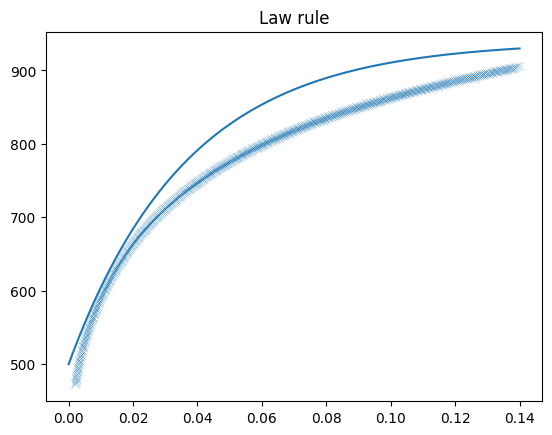

In [262]:
"""--------------------------------------CHECK OF COEFFICIENTS----------------------------------------------"""

foldername = current_dir + "{}_results".format(material) + dir + "DATA" + dir
filename_out = "UT_plasticlaw.csv"
filepath = foldername + filename_out

df_law = pd.read_csv(filepath)

ymod = df_law.iloc[0, df_law.columns.get_loc("YoungModulus")]
ep = df_law["PlasticStrain"].values

sigma = df_law["PlasticStress"].values

def swift(ep):
    return(a * (b + ep) ** c)
swift = np.vectorize(swift)

def voce(ep):
    return(a + b * (1 - np.exp(- c * ep)))

voce = np.vectorize(voce)

fig, ax = plt.subplots(1,1)

X = np.linspace(0, np.max(ep), 100)

if law == "swift" :
    Y = swift(X)
elif law == "voce":
    Y = voce(X)

ax.plot(X, Y)
ax.set_title("Law rule")

ax.scatter(ep, sigma, marker="x", linewidths=0.1 )
plt.show()

In [263]:
"""----------------------------------------------------FIXING PARAMETERS-----------------------------------------------------------------------------"""

a1 = 3
a2 = 3
a3 = 3
a4 = 3
a5 = 3
a6 = 3
b1 = 0
b2 = 0
b3 = 0
b4 = 0
b5 = 0
b6 = 0
b7 = 0
b8 = 0
b9 = 1
b10 = 0
b11 = 0
b12 = 0
b13 = 1
b14 = 1
b15 = 0
b16 = 0
b17 = 0
b18 = 0
b19 = 0
b20 = 1
b21 = 1
b22 = 1

coeff_deg2 = np.array([a1, a2, a3, a4, a5, a6])
coeff_deg4 = np.array([b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22])

def adapt_coeff(adapt, degree, coeff):
    if adapt :
        if degree == 2:
            return coeff_deg2
        elif degree == 4:
            return coeff_deg4
    return coeff

coeff = adapt_coeff(adapt, degree, coeff)

print(coeff)

[13.06174278 20.1601173  20.93721919 23.08148851 14.15854431 20.20485438
 12.75838811 17.50427561  8.89836518 13.32155721 17.34918824 12.04193624
 17.51814413  9.24269214  2.95465057 -3.12039989 18.36032246 13.77283008
 16.44503631 18.53753833 18.77689701  8.69818606]


In [264]:
"""----------------------------------------------------TESTING FUNCTIONS (PLOT & CONVEXITY)-----------------------------------------------------------------"""
## WRAP FUNCTION BEFORE USING PLOT IMPLICIT
def plot_implicit(yf, bbox=(-1.5,1.5)):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''
    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    A = np.linspace(xmin, xmax, 50) # resolution of the contour
    B = np.linspace(xmin, xmax, 10) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    print("Début du plot sur XY")
    for z in B: # plot contours in the XY plane
        X,Y = A1,A2
        Z = yf(X,Y,z) - 1
        cset = ax.contour(X, Y, Z+z, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z
    print("Fin du plot sur XY")
    print("Début du plot sur XZ")
    for y in B: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = yf(X,y,Z) - 1
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    print("Fin du plot sur XZ")
    print("Début du plot sur YZ")
    for x in B: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = yf(x,Y,Z) - 1
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')
    print("Fin du plot sur YZ")
    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

    plt.show()

In [265]:
def plot_implicit_coeff(coeff, bbox=(-1.5,1.5)):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''

    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig, ax = plt.subplots(nrows = 1, ncols = 3, subplot_kw={"projection":"3d"})
    A = np.linspace(xmin, xmax, 50) # resolution of the contour
    B = np.linspace(xmin, xmax, 10) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    def f(S):
        return polyN(S, coeff)

    for i in range(3):

        if i == 0:
            f_plane = lambda x, y, z : f(np.array([x, y, 0, z, 0, 0]))
        elif i == 1:
            f_plane = lambda x, y, z : f(np.array([x, y, 0, 0, z, 0]))
        else :
            f_plane = lambda x, y, z : f(np.array([x, y, 0, 0, 0, z]))
        
        f_plane = np.vectorize(f_plane)

        print("Début du plot sur XY")
        for z in B: # plot contours in the XY plane
            X,Y = A1,A2
            Z = f_plane(X,Y,z) - 1
            ax[i].contour(X, Y, Z+z, [z], zdir='z')
            # [z] defines the only level to plot for this contour for this value of z
        print("Fin du plot sur XY")
        print("Début du plot sur XZ")
        for y in B: # plot contours in the XZ plane
            X,Z = A1,A2
            Y = f_plane(X,y,Z) - 1
            ax[i].contour(X, Y+y, Z, [y], zdir='y')

        print("Fin du plot sur XZ")
        print("Début du plot sur YZ")
        for x in B: # plot contours in the YZ plane
            Y,Z = A1,A2
            X = f_plane(x,Y,Z) - 1
            ax[i].contour(X+x, Y, Z, [x], zdir='x')
        print("Fin du plot sur YZ")
        # must set plot limits because the contour will likely extend
        # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
        # to encompass all values in the contour.
        ax[i].set_zlim3d(zmin,zmax)
        ax[i].set_xlim3d(xmin,xmax)
        ax[i].set_ylim3d(ymin,ymax)

    plt.show()

if plot:
    plot_implicit_coeff(coeff)


In [266]:
"""-------------------------------------------------OUTPUT---------------------------------------------------------------------------------------------"""
def write_coeff_user(coeff, protomodel, degree, material, nb_virtual_pt):
    filename = "{}_deg{}_{}.txt".format(material, degree, protomodel)
    foldername = current_dir + material + "_results" + dir + "COEFF" + dir
    filepath = foldername + filename

    n = len(coeff)
    with open(filepath, "w") as file:
        file.write("#Coefficients poly{} for {} based on {} points from the {} protomodel\n".format(degree, material, nb_virtual_pt, protomodel))
        file.write("Number of coefficients : {}\n".format(n))
        for i in range(n):
            file.write("{} : {}\n".format(i + 1, coeff[i]))
            
def write_coeff_abq(coeff, protomodel, degree, material):
    filename = "{}_abq_deg{}_{}.inp".format(material, degree, protomodel)
    foldername = current_dir + material + "_results" + dir + "COEFF" + dir
    filepath = foldername + filename

    n = len(coeff)
    with open(filepath, "w") as file:
        file.write("*USER MATERIAL, constants={}\n".format(7 + nmon_abq))
        file.write("{}, {}, {}, {}, {}, {}, {}, ".format(ymod, enu, a, b, c, degree, nmon_abq))
        n0 = 0
        n0_abq = 0
        while n0_abq < nmon :
            for m in range(0, degree + 1):
                for l in range(0, degree + 1 - m):
                    for k in range(0, degree + 1 - m - l):
                        for j in range(0, degree + 1 - m - l - k):
                            i = degree - m - l - k - j
                            i0, j0, k0, l0, m0 = powers[n0]
                            if (i==i0) and (j==j0) and (k==k0) and (l==l0) and (m==m0):
                                file.write("{}, ".format(coeff[n0]))
                                n0 = n0 + 1
                            else:
                                file.write("0, ")
                            n0_abq = n0_abq + 1
                            if (n0_abq + 7) % 8 == 0:
                                file.write("\n")
                            
        file.write("\n")
        file.write("*DENSITY\n")
        file.write("{}".format(density))


In [267]:
if export_coeff_user:
    write_coeff_user(coeff, protomodel, degree, material, nb_virtual_pt)
if export_coeff_abq:
    write_coeff_abq(coeff, protomodel, degree, material)